<h1 style="text-align: center;">RNN MODEL WITH MACD TRIGGER</h1>

<h2>Initialization</h2>

In [1]:
# Libraries
import MetaTrader5 as mt5  # pip install MetaTrader5
import pandas as pd  # pip install pandas
import talib
import numpy as np
from datetime import datetime
import plotly.express as px  # pip install plotly

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)

import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

c:\Users\jeanc\trading\rnn\venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
# start the platform with initialize()
mt5.initialize()

True

In [3]:
# login to Trade Account with login()
# make sure that trade server is enabled in MT5 client terminal

login = 5044174558
password = '-a6bNxSy'
server = 'MetaQuotes-Demo'

mt5.login(login, password, server)

True

In [4]:
# get account info
account_info = mt5.account_info()
print(account_info)

# getting specific account data
login_number = account_info.login
balance = account_info.balance
equity = account_info.equity

print()
print('login: ', login_number)
print('balance: ', balance)
print('equity: ', equity)

AccountInfo(login=5044174558, trade_mode=0, leverage=100, limit_orders=200, margin_so_mode=0, trade_allowed=True, trade_expert=True, margin_mode=2, currency_digits=2, fifo_close=False, balance=1000.0, credit=0.0, profit=0.0, equity=1000.0, margin=0.0, margin_free=1000.0, margin_level=0.0, margin_so_call=50.0, margin_so_so=30.0, margin_initial=0.0, margin_maintenance=0.0, assets=0.0, liabilities=0.0, commission_blocked=0.0, name='Jean-Charles Jacques', server='MetaQuotes-Demo', currency='EUR', company='MetaQuotes Ltd.')

login:  5044174558
balance:  1000.0
equity:  1000.0


<h2>GET MARKET DATA</h2>

In [5]:
symbol = "EURUSD"
info = mt5.symbol_info(symbol)

point = info.point       # ex: 0.00001
digits = info.digits     # ex: 5

pip_value = point * 10   # 1 pip en valeur de prix


In [6]:
timeframe = mt5.TIMEFRAME_M5
start_pos = 0
num_bars = 10000

In [7]:
def timeframe_to_str(tf):
    mapping = {
        mt5.TIMEFRAME_M1: "M1",
        mt5.TIMEFRAME_M5: "M5",
        mt5.TIMEFRAME_M15: "M15",
        mt5.TIMEFRAME_M30: "M30",
        mt5.TIMEFRAME_H1: "H1",
        mt5.TIMEFRAME_H4: "H4",
        mt5.TIMEFRAME_D1: "D1",
    }
    return mapping.get(tf, "UNKNOWN")

print(timeframe_to_str(timeframe))

M5


In [ ]:
# ohlc_data
ohlc_data = pd.DataFrame(mt5.copy_rates_from_pos(symbol, timeframe, start_pos, num_bars))

fig = px.line(ohlc_data, x=ohlc_data['time'], y=ohlc_data['close'])
fig.show()

ohlc_data

In [ ]:
ohlc_data.to_csv(f'data/{symbol}_{timeframe_to_str(timeframe)}.csv')

<h2>COMMON FUNCTIONS</h2>

In [8]:
def plot_loss(history, title="Model Loss Over Epochs"):
    loss_df = pd.DataFrame({
        "Epoch": range(1, len(history.history["loss"]) + 1),
        "Train Loss": history.history["loss"],
        "Validation Loss": history.history.get("val_loss")
    })

    fig = px.line(
        loss_df,
        x="Epoch",
        y=["Train Loss", "Validation Loss"],
        title=title,
        labels={"value": "Loss", "variable": "Metric"}
    )

    fig.update_layout(
        hovermode="x unified",
        template="plotly_white"
    )

    fig.show()

<h2>TRAIN MODEL</h2>

In [9]:
# Charger le dataset
df = pd.read_csv(f'data/{symbol}_{timeframe_to_str(timeframe)}.csv')
df = df[['close', 'high', 'low', 'tick_volume']].dropna()

In [10]:
# Calcul du MACD
macd, macd_signal, macd_hist = talib.MACD(
    df["close"].values,
    fastperiod=12,
    slowperiod=26,
    signalperiod=9
)

df["macd"] = macd
df["macd_signal"] = macd_signal
df["macd_hist"] = macd_hist


In [11]:
# Calcul du trigger
df["macd_trigger"] = 0

df.loc[
    (df["macd_hist"].shift(1) < 0) & (df["macd_hist"] > 0),
    "macd_trigger"
] = 1   # LONG

df.loc[
    (df["macd_hist"].shift(1) > 0) & (df["macd_hist"] < 0),
    "macd_trigger"
] = -1  # SHORT


In [12]:
features = ["close", "tick_volume", "macd_hist"]
df_model = df[features + ["macd_trigger"]].dropna()

In [13]:
# Normalisation (CRUCIAL pour un RNN)
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df_model[features])

In [89]:
WINDOW_SIZE = 60
HORIZON_MAX = 36
MARGE = 5

def create_sequences_on_trigger_variable_exit(df, scaled_data, window, horizon_max=3):
    X, idx_list = [], []

    for i in range(window, len(df) - horizon_max):
        if df["macd_trigger"].iloc[i] == 0:
            continue

        X.append(scaled_data[i-window:i])
        idx_list.append(i)  # POSITION, pas index temporel

    return np.array(X), np.array(idx_list)


In [90]:
X, idx = create_sequences_on_trigger_variable_exit(
    df_model,
    scaled_features,
    WINDOW_SIZE,
    HORIZON_MAX
)

split = int(0.8 * len(X))

X_train, X_test = X[:split], X[split:]
idx_train, idx_test = idx[:split], idx[split:]

In [91]:
def simulate_trade_exit(entry, trade, future_prices, sl_pips, tp_pips, pip_value):
    sl_price = entry - trade * sl_pips * pip_value
    tp_price = entry + trade * tp_pips * pip_value

    for price in future_prices:
        if trade == 1:
            if price <= sl_price:
                return -sl_pips
            if price >= tp_price:
                return tp_pips
        else:
            if price >= sl_price:
                return -sl_pips
            if price <= tp_price:
                return tp_pips

    # sortie au dernier prix si rien touché
    return (future_prices[-1] - entry) / pip_value * trade


In [92]:
def build_hit_labels_setup(
    df_model,
    df_full,
    idx_list,
    horizon_max=36,
    marge=5,  # pips
    pip_value=0.0001
):
    y_hit = []

    for idx in idx_list:
        macd_trig = df_model.loc[idx, "macd_trigger"]

        if macd_trig == 0:
            y_hit.append(0)
            continue

        entry = df_full.loc[idx, "close"]
        loc = df_full.index.get_loc(idx)

        future_prices = df_full.iloc[
            loc + 1 : loc + horizon_max + 1
        ]["close"].values

        if len(future_prices) < horizon_max:
            y_hit.append(0)
            continue

        if macd_trig == 1:
            hit = np.max(future_prices) >= entry + marge * pip_value
        else:
            hit = np.min(future_prices) <= entry - marge * pip_value

        y_hit.append(int(hit))

    return np.array(y_hit)


In [93]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)
]

y_train_hit = build_hit_labels_setup(
    df_model,
    df,
    idx_train,
    horizon_max=HORIZON_MAX,
    marge=MARGE,
    pip_value=pip_value
)

y_test_hit = build_hit_labels_setup(
    df_model,
    df,
    idx_test,
    horizon_max=HORIZON_MAX,
    marge=MARGE,
    pip_value=pip_value
)


pos = (y_train_hit == 1).sum()
neg = (y_train_hit == 0).sum()

class_weight = {
    0: pos / (pos + neg),
    1: neg / (pos + neg)
}

print("Class weight:", class_weight)

model = Sequential([
    Input(shape=(WINDOW_SIZE, X_train.shape[2])),
    LSTM(32),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    X_train, y_train_hit,
    validation_data=(X_test, y_test_hit),
    epochs=60,
    batch_size=32,
    shuffle=False,
    callbacks=callbacks,
    class_weight=class_weight,
    verbose=1
)

Class weight: {0: 0.03951367781155015, 1: 0.9604863221884499}
Epoch 1/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6033 - loss: 0.0525 - val_accuracy: 0.9818 - val_loss: 0.6702 - learning_rate: 0.0010
Epoch 2/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6474 - loss: 0.0526 - val_accuracy: 0.9818 - val_loss: 0.6151 - learning_rate: 0.0010
Epoch 3/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7827 - loss: 0.0523 - val_accuracy: 0.9818 - val_loss: 0.5722 - learning_rate: 0.0010
Epoch 4/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7675 - loss: 0.0514 - val_accuracy: 0.9818 - val_loss: 0.4985 - learning_rate: 0.0010
Epoch 5/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6839 - loss: 0.0500 - val_accuracy: 0.9818 - val_loss: 0.3014 - learning_rate: 0.0010
Epoch 6/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5532 - loss: 0.0527 - val_accuracy: 0.9758 - val_loss: 0.4368 - learning_rate: 0.0010
Epoch 7/60
21/21 ━━━━━━━━━━━━━━━

In [94]:
plot_loss(history)

<h2>TEST VALIDATION</h2>

In [95]:
def build_trade_df_variable_horizon(
    df_model,
    df_full,
    idx_part,
    hit_proba_part,
    horizon_max=36,
    threshold=0.55,
    marge_pips=5,
    pip_value=0.0001
):
    trade_rows = []

    for idx, proba in zip(idx_part, hit_proba_part):

        macd_trig = df_model.loc[idx, "macd_trigger"]

        # 1️⃣ Pas de signal directionnel
        if macd_trig == 0:
            continue

        # 2️⃣ Filtre ML
        if proba < threshold:
            continue

        # 3️⃣ Direction UNIQUEMENT via MACD
        trade = 1 if macd_trig == 1 else -1

        entry_price = df_full.loc[idx, "close"]
        entry_loc = df_full.index.get_loc(idx)

        future_prices = df_full.iloc[
            entry_loc + 1 : entry_loc + horizon_max + 1
        ]["close"].values

        if len(future_prices) < horizon_max:
            continue

        # 4️⃣ Validation HIT avec MARGE (COHÉRENTE AVEC LE LABEL)
        if trade == 1:
            target = entry_price + marge_pips * pip_value
            hit = np.max(future_prices) >= target
            best_exit = np.max(future_prices)
        else:
            target = entry_price - marge_pips * pip_value
            hit = np.min(future_prices) <= target
            best_exit = np.min(future_prices)

        trade_rows.append({
            "time": idx,
            "entry": entry_price,
            "close": entry_price,
            "trade": trade,
            "hit": int(hit),
            "best_exit": best_exit,
            "hit_proba": proba,
            "macd_trigger": macd_trig
        })

    df_trades = pd.DataFrame(trade_rows)

    if df_trades.empty:
        return df_trades

    return df_trades.set_index("time")

In [96]:
import plotly.graph_objects as go

def plot_trades(trade_df, df_full, title=f"MACD + LSTM Trades ({timeframe_to_str(timeframe)})"):
    fig = go.Figure()

    # prix
    fig.add_trace(go.Scatter(
        x=df_full.index,
        y=df_full["close"],
        mode="lines",
        name="Close",
        line=dict(color="black")
    ))

    # LONG
    long_trades = trade_df[trade_df["trade"] == 1]
    fig.add_trace(go.Scatter(
        x=long_trades.index,
        y=long_trades["close"],
        mode="markers",
        name="LONG",
        marker=dict(symbol="triangle-up", size=10, color="green")
    ))

    # SHORT
    short_trades = trade_df[trade_df["trade"] == -1]
    fig.add_trace(go.Scatter(
        x=short_trades.index,
        y=short_trades["close"],
        mode="markers",
        name="SHORT",
        marker=dict(symbol="triangle-down", size=10, color="red")
    ))

    fig.update_layout(
        title=title,
        hovermode="x unified",
        template="plotly_white"
    )

    fig.show()


In [97]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_trades_with_macd(
    trade_df,
    df_full,
    title=f"MACD + LSTM Trades ({timeframe_to_str(timeframe)})"
):
    fig = make_subplots(
        rows=2,
        cols=1,
        shared_xaxes=True,
        vertical_spacing=0.08,
        row_heights=[0.65, 0.35],
        subplot_titles=("Price & Trades", "MACD")
    )

    # =====================
    # 1️⃣ PRIX
    # =====================
    fig.add_trace(
        go.Scatter(
            x=df_full.index,
            y=df_full["close"],
            mode="lines",
            name="Close",
            line=dict(color="black", width=1)
        ),
        row=1, col=1
    )

    # LONG
    long_trades = trade_df[trade_df["trade"] == 1]
    fig.add_trace(
        go.Scatter(
            x=long_trades.index,
            y=long_trades["close"],
            mode="markers",
            name="LONG",
            marker=dict(symbol="triangle-up", size=10, color="green")
        ),
        row=1, col=1
    )

    # SHORT
    short_trades = trade_df[trade_df["trade"] == -1]
    fig.add_trace(
        go.Scatter(
            x=short_trades.index,
            y=short_trades["close"],
            mode="markers",
            name="SHORT",
            marker=dict(symbol="triangle-down", size=10, color="red")
        ),
        row=1, col=1
    )

    # =====================
    # 2️⃣ MACD
    # =====================
    fig.add_trace(
        go.Scatter(
            x=df_full.index,
            y=df_full["macd"],
            mode="lines",
            name="MACD",
            line=dict(color="blue")
        ),
        row=2, col=1
    )

    fig.add_trace(
        go.Scatter(
            x=df_full.index,
            y=df_full["macd_signal"],
            mode="lines",
            name="Signal",
            line=dict(color="orange", dash="dot")
        ),
        row=2, col=1
    )

    # Histogramme MACD
    fig.add_trace(
        go.Bar(
            x=df_full.index,
            y=df_full["macd_hist"],
            name="Histogram",
            marker_color=df_full["macd_hist"].apply(
                lambda x: "green" if x >= 0 else "red"
            ),
            opacity=0.4
        ),
        row=2, col=1
    )

    # =====================
    # LAYOUT
    # =====================
    fig.update_layout(
        title=title,
        hovermode="x unified",
        template="plotly_white",
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )

    fig.show()


In [98]:
def direction_metrics(trade_df):
    """
    trade_df doit contenir :
    - trade        ∈ {-1, +1}
    - trade_result ∈ {-1, +1}
    - hit          ∈ {0, 1}
    """

    metrics = {}

    n_trades = len(trade_df)
    n_ok = trade_df["hit"].sum()
    n_nok = n_trades - n_ok

    metrics["Trades"] = int(n_trades)
    metrics["Direction_OK"] = int(n_ok)
    metrics["Direction_NOK"] = int(n_nok)
    metrics["Accuracy_%"] = float(100 * n_ok / n_trades) if n_trades > 0 else np.nan

    # --- LONG / SHORT breakdown ---
    long_trades = trade_df[trade_df["trade"] == 1]
    short_trades = trade_df[trade_df["trade"] == -1]

    if len(long_trades) > 0:
        metrics["LONG_trades"] = int(len(long_trades))
        metrics["LONG_accuracy_%"] = float(100 * long_trades["hit"].mean())
    else:
        metrics["LONG_trades"] = 0
        metrics["LONG_accuracy_%"] = np.nan

    if len(short_trades) > 0:
        metrics["SHORT_trades"] = int(len(short_trades))
        metrics["SHORT_accuracy_%"] = float(100 * short_trades["hit"].mean())
    else:
        metrics["SHORT_trades"] = 0
        metrics["SHORT_accuracy_%"] = np.nan

    # --- biais directionnel ---
    metrics["LONG_%"] = float(100 * (trade_df["trade"] == 1).mean())
    metrics["SHORT_%"] = float(100 * (trade_df["trade"] == -1).mean())

    return metrics



In [99]:
# === Prédictions ===
hit_proba_test = model.predict(X_test).ravel()

print("Hit proba stats:")
print("min :", hit_proba_test.min())
print("mean:", hit_proba_test.mean())
print("max :", hit_proba_test.max())

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Hit proba stats:
min : 0.09203861
mean: 0.096121125
max : 0.101340845


In [100]:
threshold_ml = 0.01
y_test_pred = (hit_proba_test >= threshold_ml).astype(int)

metrics_ml = {
    "Accuracy": accuracy_score(y_test_hit, y_test_pred),
    "Precision": precision_score(y_test_hit, y_test_pred, zero_division=0),
    "Recall": recall_score(y_test_hit, y_test_pred, zero_division=0),
    "F1": f1_score(y_test_hit, y_test_pred, zero_division=0),
    "ROC_AUC": roc_auc_score(y_test_hit, hit_proba_test)
}

print("📊 ML metrics on TEST:")
for k, v in metrics_ml.items():
    print(f"{k}: {v:.3f}")

📊 ML metrics on TEST:
Accuracy: 0.018
Precision: 0.018
Recall: 1.000
F1: 0.036
ROC_AUC: 0.605


In [101]:
cm = confusion_matrix(y_test_hit, y_test_pred)

print("Confusion matrix:")
print(cm)


Confusion matrix:
[[  0 162]
 [  0   3]]


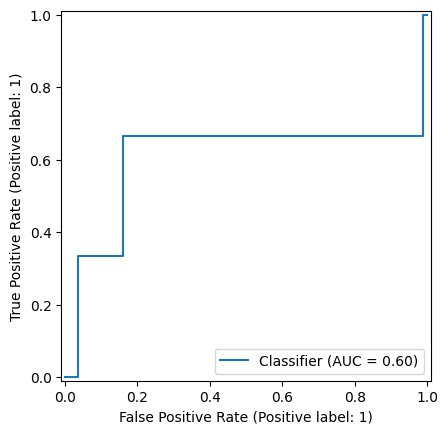

In [102]:
RocCurveDisplay.from_predictions(y_test_hit, hit_proba_test)
plt.show()


In [103]:
def build_trade_df_for_plot(
    df_model,
    df_full,
    idx_part,
    hit_proba_part,
    threshold=0.55
):
    rows = []

    for idx, proba in zip(idx_part, hit_proba_part):

        macd_trig = df_model.loc[idx, "macd_trigger"]

        # pas de signal
        if macd_trig == 0:
            continue

        # filtre ML
        if proba < threshold:
            continue

        trade = 1 if macd_trig == 1 else -1

        rows.append({
            "time": idx,
            "trade": trade,
            "close": df_full.loc[idx, "close"],
            "hit_proba": proba
        })

    if not rows:
        return pd.DataFrame()

    return pd.DataFrame(rows).set_index("time")

<h2>WALK-FORWARD</h2>

In [104]:
TRAIN_SIZE = 1000   # bougies M5 (~3–4 jours)
TEST_SIZE  = 300    # bougies M5 (~1 jour)
STEP_SIZE  = 300    # on avance d’un test
THRESHOLD  = 0.55

In [105]:
def scale_train_test(train_df, test_df, feature_cols):
    """
    Fit le scaler sur TRAIN uniquement,
    puis transforme TRAIN et TEST avec le même scaler.
    """
    scaler = MinMaxScaler()
    
    X_train_scaled = scaler.fit_transform(train_df[feature_cols])
    X_test_scaled  = scaler.transform(test_df[feature_cols])
    
    return X_train_scaled, X_test_scaled


In [106]:
def walk_forward_backtest(
    df,
    df_model,
    feature_cols,
    window_size,
    horizon_max,
    train_size,
    test_size,
    step_size,
    marge,
    pip_value=0.0001,
    threshold=0.55
):
    results = []
    all_trades = []
    start = window_size

    while start + train_size + test_size < len(df_model):

        train_start = start
        train_end   = start + train_size
        test_end    = train_end + test_size

        df_train = df_model.iloc[train_start:train_end]
        df_test  = df_model.iloc[train_end:test_end]

        # === Scaling ===
        X_train_scaled, X_test_scaled = scale_train_test(
            df_train, df_test, feature_cols
        )

        # === Séquences ===
        X_train, idx_train = create_sequences_on_trigger_variable_exit(
            df_train,
            X_train_scaled,
            window_size,
            horizon_max
        )

        X_test, idx_test = create_sequences_on_trigger_variable_exit(
            df_test,
            X_test_scaled,
            window_size,
            horizon_max
        )

        if len(X_train) < 50 or len(X_test) < 10:
            start += step_size
            continue

        # === Indices absolus ===
        idx_train_abs = df_model.index[train_start + idx_train]
        idx_test_abs  = df_model.index[train_end + idx_test]

        # === Labels HIT basés sur SL/TP ===
        y_train_hit = build_hit_labels_setup(
            df_model=df_model,
            df_full=df,
            idx_list=idx_train_abs,
            horizon_max=horizon_max,
            marge=marge,
            pip_value=pip_value
        )

        if y_train_hit.sum() < 5:
            start += step_size
            continue

        # === Modèle ===
        model = Sequential([
            Input(shape=(window_size, X_train.shape[2])),
            LSTM(32),
            Dropout(0.3),
            Dense(1, activation="sigmoid")
        ])

        model.compile(
            optimizer="adam",
            loss="binary_crossentropy"
        )

        model.fit(
            X_train,
            y_train_hit,
            epochs=30,
            batch_size=32,
            shuffle=False,
            verbose=0
        )

        # === Prédictions ===
        hit_proba_test = model.predict(X_test).ravel()

        # === Trades TEST ===
        trade_df_test = build_trade_df_variable_horizon(
            df_model=df_model,
            df_full=df,
            idx_part=idx_test_abs,
            hit_proba_part=hit_proba_test,
            horizon_max=horizon_max,
            threshold=threshold,
            marge_pips=marge,        # 🔥 même marge que les labels
            pip_value=pip_value
        )


        if not trade_df_test.empty:
            all_trades.append(trade_df_test)
            results.append({
                "start_idx": train_start,
                "trades": len(trade_df_test),
                "accuracy": trade_df_test["hit"].mean()
            })

        start += step_size

    wf_results = pd.DataFrame(results)
    wf_trades  = pd.concat(all_trades).sort_index() if all_trades else pd.DataFrame()

    return wf_results, wf_trades


In [107]:
FEATURE_COLS = ["close", "tick_volume"]

wf_results, wf_trades = walk_forward_backtest(
    df=df,
    df_model=df_model,
    feature_cols=FEATURE_COLS,
    window_size=WINDOW_SIZE,
    horizon_max=HORIZON_MAX,
    train_size=TRAIN_SIZE,
    test_size=TEST_SIZE,
    step_size=STEP_SIZE,
    marge=MARGE,
    pip_value=pip_value,
    threshold=THRESHOLD
)

print(wf_results)
print("Nb total de trades:", len(wf_trades))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [108]:
import plotly.express as px

fig = px.line(
    wf_results,
    y="accuracy",
    title="Walk-forward accuracy over time"
)

fig.update_yaxes(range=[0, 1])

fig.show()


In [109]:
weighted_acc = (
    (wf_results["accuracy"] * wf_results["trades"]).sum()
    / wf_results["trades"].sum()
)
print(weighted_acc)

0.592156862745098


In [110]:
plot_trades_with_macd(
    trade_df=wf_trades,
    df_full=df,
    title="Walk-Forward MACD + LSTM Trades (M5)"
)

# GRID SEARCH FOR SL/TP CONFIGURATION

In [111]:
SL_PIPS = [5, 10, 15, 20]
TP_PIPS = [5, 10, 15, 20]

In [112]:
def evaluate_sl_tp(trade_df, sl_pips, tp_pips, df_full, horizon, pip_value):
    pnl = []

    for idx, row in trade_df.iterrows():
        entry = row["entry"]
        trade = row["trade"]
        loc = df_full.index.get_loc(idx)

        future_prices = df_full.iloc[loc+1 : loc+horizon+1]["close"].values
        if len(future_prices) == 0:
            continue

        pnl.append(
            simulate_trade_exit(entry, trade, future_prices, sl_pips, tp_pips, pip_value)
        )

    pnl = np.array(pnl)

    return {
        "trades": len(pnl),
        "win_rate": np.mean(pnl > 0),
        "avg_pnl": pnl.mean(),
        "expectancy": pnl.mean(),
        "profit_factor": pnl[pnl>0].sum() / abs(pnl[pnl<0].sum()) if np.any(pnl<0) else np.nan,
        "max_dd": np.min(np.cumsum(pnl))
    }


In [113]:
def build_sl_tp_df(
    trade_df,
    df_full,
    sl_pips_list,
    tp_pips_list,
    horizon,
    pip_value
):
    results = []

    for sl in sl_pips_list:
        for tp in tp_pips_list:

            metrics = evaluate_sl_tp(
                trade_df=trade_df,
                sl_pips=sl,
                tp_pips=tp,
                df_full=df_full,
                horizon=horizon,
                pip_value=pip_value
            )

            # Sécurité : ignorer les cas sans trades
            if metrics["trades"] == 0:
                continue

            metrics.update({
                "SL_pips": sl,
                "TP_pips": tp,
                "RR": tp / sl if sl > 0 else np.nan
            })

            results.append(metrics)

    return pd.DataFrame(results)

In [114]:
sl_tp_df = build_sl_tp_df(
    trade_df=wf_trades,
    df_full=df,
    sl_pips_list=SL_PIPS,
    tp_pips_list=TP_PIPS,
    horizon=HORIZON_MAX,
    pip_value=0.0001
)

print(sl_tp_df.sort_values("expectancy", ascending=False).head())

    trades  win_rate   avg_pnl  expectancy  profit_factor  max_dd  SL_pips  \
3      255  0.337255  0.566667    0.566667       1.179883   -23.7        5   
2      255  0.349020  0.476078    0.476078       1.154002    -9.2        5   
7      255  0.454902  0.459216    0.459216       1.107293   -10.0       10   
11     255  0.486275  0.272941    0.272941       1.057464   -54.6       15   
6      255  0.466667  0.248235    0.248235       1.059098   -10.0       10   

    TP_pips        RR  
3        20  4.000000  
2        15  3.000000  
7        20  2.000000  
11       20  1.333333  
6        15  1.500000  


In [115]:
# Préparation des données (pivot)
def pivot_sl_tp(df, value_col):
    return df.pivot(
        index="SL_pips",
        columns="TP_pips",
        values=value_col
    )

In [116]:
# Heatmap – Expectancy (⭐ PRIORITAIRE)

expectancy_pivot = pivot_sl_tp(sl_tp_df, "expectancy")

fig = px.imshow(
    expectancy_pivot,
    text_auto=".2f",
    color_continuous_scale="RdYlGn",
    title="Heatmap Expectancy (pips) – SL / TP",
    labels=dict(x="TP (pips)", y="SL (pips)", color="Expectancy")
)

fig.update_layout(
    template="plotly_white",
    xaxis_side="top"
)

fig.show()


In [117]:
# Heatmap – Profit Factor

pf_pivot = pivot_sl_tp(sl_tp_df, "profit_factor")

fig = px.imshow(
    pf_pivot,
    text_auto=".2f",
    color_continuous_scale="Viridis",
    title="Heatmap Profit Factor – SL / TP",
    labels=dict(x="TP (pips)", y="SL (pips)", color="Profit Factor")
)

fig.update_layout(
    template="plotly_white",
    xaxis_side="top"
)

fig.show()

In [118]:
# Heatmap – Max Drawdown (⚠️ risque)

dd_pivot = pivot_sl_tp(sl_tp_df, "max_dd")

fig = px.imshow(
    dd_pivot,
    text_auto=".1f",
    color_continuous_scale="RdYlGn_r",
    title="Heatmap Max Drawdown (pips) – SL / TP",
    labels=dict(x="TP (pips)", y="SL (pips)", color="Max DD")
)

fig.update_layout(
    template="plotly_white",
    xaxis_side="top"
)

fig.show()

In [119]:
# Heatmap – Win Rate

wr_pivot = pivot_sl_tp(sl_tp_df, "win_rate")

fig = px.imshow(
    wr_pivot,
    text_auto=".2%",
    color_continuous_scale="Blues",
    title="Heatmap Win Rate – SL / TP",
    labels=dict(x="TP (pips)", y="SL (pips)", color="Win Rate")
)

fig.update_layout(
    template="plotly_white",
    xaxis_side="top"
)

fig.show()

In [120]:
def select_best_sl_tp(
    sl_tp_df,
    min_trades=30,
    max_drawdown=None,
    min_profit_factor=1.2
):
    """
    Sélectionne la meilleure configuration SL / TP
    selon des critères robustes.
    """

    df = sl_tp_df.copy()

    # 1️⃣ Filtrer configurations statistiquement faibles
    df = df[df["trades"] >= min_trades]

    # 2️⃣ Filtrer sur profit factor
    df = df[df["profit_factor"] >= min_profit_factor]

    # 3️⃣ Filtrer sur drawdown si demandé
    if max_drawdown is not None:
        df = df[df["max_dd"] >= -abs(max_drawdown)]

    if len(df) == 0:
        print("⚠️ Aucune configuration robuste trouvée.")
        return None

    # 4️⃣ Score composite (robuste)
    df["score"] = (
        df["expectancy"] *
        df["profit_factor"] /
        abs(df["max_dd"])
    )

    # 5️⃣ Meilleure config
    best = df.sort_values("score", ascending=False).iloc[0]

    return best

In [122]:
best_sl_tp = select_best_sl_tp(
    sl_tp_df,
    min_trades=3,
    max_drawdown=50,      # pips
    min_profit_factor=1
)

print(best_sl_tp)

trades           255.000000
win_rate           0.349020
avg_pnl            0.476078
expectancy         0.476078
profit_factor      1.154002
max_dd            -9.200000
SL_pips            5.000000
TP_pips           15.000000
RR                 3.000000
score              0.059717
Name: 2, dtype: float64


# EQUITY SIMULATION

In [123]:
def equity_curve_from_expectancy(
    stats,
    lot=0.1,
    capital_initial=1000,
    pip_value_per_lot=10
):
    """
    stats : dict ou Series contenant
        - trades
        - expectancy (en pips)
    lot : taille de position (ex: 0.1)
    capital_initial : capital de départ en €
    """

    trades = int(stats["trades"])
    expectancy_pips = stats["expectancy"]

    # € gagnés en moyenne par trade
    expectancy_eur = expectancy_pips * lot * pip_value_per_lot

    # série des gains espérés
    pnl_eur = np.full(trades, expectancy_eur)

    equity = capital_initial + np.cumsum(pnl_eur)

    df_equity = pd.DataFrame({
        "trade": np.arange(1, trades + 1),
        "pnl_eur": pnl_eur,
        "equity_eur": equity
    })

    # graphique
    fig = px.line(
        df_equity,
        x="trade",
        y="equity_eur",
        title=(
            f"Évolution du capital (espérée)<br>"
            f"Lot={lot} | Capital initial={capital_initial} € | "
            f"Expectancy={expectancy_pips:.2f} pips"
        ),
        labels={
            "trade": "Trade #",
            "equity_eur": "Capital (€)"
        }
    )

    fig.show()

    return df_equity

In [ ]:
'''
trades           255.000000
win_rate           0.349020
avg_pnl            0.476078
expectancy         0.476078
profit_factor      1.154002
max_dd            -9.200000
SL_pips            5.000000
TP_pips           15.000000
RR                 3.000000
score              0.059717
'''

stats = {
    "trades": 255,
    "expectancy": 0.476078,
    "profit_factor": 1.154002,
    "max_dd": -10.9,
    "SL": 12,
    "TP": 20,
    "score": 0.046097
}

df_equity = equity_curve_from_expectancy(
    stats,
    lot=0.1,
    capital_initial=1000
)


# EQUITY SIMULATION (REAL)

In [ ]:
def simulate_exit_price(
    entry_price,
    trade_dir,
    future_prices,
    sl_pips,
    tp_pips,
    pip_value
):
    """
    entry_price : prix d'entrée
    trade_dir   : +1 (long) ou -1 (short)
    future_prices : array des prix close futurs
    sl_pips / tp_pips : SL / TP en pips
    """

    sl_price = entry_price - trade_dir * sl_pips * pip_value
    tp_price = entry_price + trade_dir * tp_pips * pip_value

    for price in future_prices:
        if trade_dir == 1:
            if price <= sl_price:
                return sl_price
            if price >= tp_price:
                return tp_price
        else:
            if price >= sl_price:
                return sl_price
            if price <= tp_price:
                return tp_price

    # si ni SL ni TP touché → sortie au dernier prix
    return future_prices[-1]


def add_exit_and_pnl(
    trade_df,
    df_prices,
    sl_pips,
    tp_pips,
    horizon,
    pip_value=0.0001
):
    trade_df = trade_df.copy()

    exit_prices = []
    pnl_pips = []

    for idx, row in trade_df.iterrows():
        entry = row["entry"]
        trade = row["trade"]

        loc = df_prices.index.get_loc(idx)
        future_prices = df_prices.iloc[
            loc + 1 : loc + horizon + 1
        ]["close"].values

        if len(future_prices) == 0:
            exit_prices.append(np.nan)
            pnl_pips.append(np.nan)
            continue

        exit_price = simulate_exit_price(
            entry,
            trade,
            future_prices,
            sl_pips,
            tp_pips,
            pip_value
        )

        exit_prices.append(exit_price)
        pnl_pips.append(
            (exit_price - entry) / pip_value * trade
        )

    trade_df["exit_price"] = exit_prices
    trade_df["pnl_pips"] = pnl_pips

    return trade_df.dropna()


In [ ]:
def build_equity_curve_real(
    trade_df,
    df_prices,
    sl_pips,
    tp_pips,
    horizon,
    capital_initial=1000.0,
    lot=0.1,
    pip_value=0.0001,
    pip_value_per_lot=10.0  # EURUSD standard
):
    """
    Construit l'equity curve réelle trade par trade
    avec SL / TP, PnL, capital et drawdown.
    """

    # 1️⃣ Calcul des exits et PnL en pips
    trade_df = add_exit_and_pnl(
        trade_df,
        df_prices,
        sl_pips=sl_pips,
        tp_pips=tp_pips,
        horizon=horizon,
        pip_value=pip_value
    )

    trade_df = trade_df.copy()

    # 2️⃣ Conversion PnL pips → €
    trade_df["pnl_eur"] = (
        trade_df["pnl_pips"]
        * pip_value_per_lot
        * lot
    )

    # 3️⃣ Equity curve
    equity = [capital_initial]
    for pnl in trade_df["pnl_eur"]:
        equity.append(equity[-1] + pnl)

    equity = equity[1:]  # on enlève le capital initial doublon

    trade_df["equity"] = equity

    # 4️⃣ Drawdown
    trade_df["equity_peak"] = trade_df["equity"].cummax()
    trade_df["drawdown"] = trade_df["equity"] - trade_df["equity_peak"]

    return trade_df

In [ ]:
trade_df_real = build_equity_curve_real(
    trade_df=wf_trades,   # ou wf_trades concaténé
    df_prices=df,
    sl_pips=stats["SL"],
    tp_pips=stats["TP"],
    horizon=HORIZON_MAX,
    capital_initial=1000,
    lot=0.1
)


In [ ]:
summary = {
    "trades": len(trade_df_real),
    "final_capital": trade_df_real["equity"].iloc[-1],
    "net_profit": trade_df_real["equity"].iloc[-1] - 1000,
    "max_drawdown_eur": trade_df_real["drawdown"].min(),
    "max_drawdown_pct": trade_df_real["drawdown"].min() / 1000 * 100,
    "win_rate": (trade_df_real["pnl_pips"] > 0).mean(),
    "profit_factor": (
        trade_df_real.loc[trade_df_real["pnl_eur"] > 0, "pnl_eur"].sum()
        /
        abs(trade_df_real.loc[trade_df_real["pnl_eur"] < 0, "pnl_eur"].sum())
    )
}

for k, v in summary.items():
    print(f"{k}: {v:.2f}")


In [ ]:
import plotly.express as px

fig = px.line(
    trade_df_real,
    y="equity",
    title=(
        f"Equity réelle trade par trade | "
        f"SL={5} TP={20} | Lot=0.1"
    ),
    labels={"equity": "Capital (€)", "index": "Trade #"}
)

fig.update_layout(
    template="plotly_white",
    hovermode="x unified"
)

fig.show()
